# Iteration 22: Multiple Replications (1)

## Plain English Summary

The model can be used with both warm-up + single long run or multiple replications (as used in the paper). We will now implement multiple replication over several steps.  The first step will

1. Introduce functionality to reset KPIs at the end of a run
2. Reorganise the main script into a single run function

> We add a test for the single_run function.


## Notebook imports

In [69]:
from IPython.display import Markdown, display, HTML
import math
import statistics
from sim_tools.distributions import Lognormal

## LLM Prompt 1 <a class="anchor" id="llm_prompt"></a>

In [70]:
display(Markdown("../01_perplexity/inputs/22_iteration.md"))

modify `Experiment` to include a method `reset_kpi` that resets the occupancy lists to empty.

modify edited script 3 into a function called `single_run(experiment)`.  The first line of code should call experiment.reset_kpi(), In a dictionary, return the relative frequencies, prob of delay, and unique values for asu and rehab 

Using script 3 code a new script that creates an instance of `Experiment`, uses `single_run` and prints out a `prob_delay_plot` for both asu and rehab 

show all code in `Experiment`, `single_run`,  the new script

## Date and time of input to LLM

> 1700 22nd July 2024

## Observations on the LLM Output

* The Stage 1 prompt worked as asked.
* An additional prompt was given to include the occupancy plots in the script that uses the single_run function


## Sources reported by the LLM

* None reported at time of generation.

## Code carried over from iteration 13

We carry over:
*  `PatientType`
*  `calculate_occupancy_frequencies` - calculate relative frequencies of occupancy observations
*  `occupancy_plot` - show occupancy as a bar chart.
*  `calculate_prob_delay`
*  `prob_delay_plot`
*  `RehabilitationUnit`
*  `AcuteStrokeUnit`
*  Functions to run ASU and rehab separately

## Model code <a class="anchor" id="model_code"></a>

### Imports

In [71]:
import simpy
import numpy as np
import matplotlib.pyplot as plt

### Experiment class

> Modified in iteration 22

In [72]:
class Experiment:
    def __init__(self, params=None):
        default_params = {
            'results_collection_period': 5 * 365,
            'warm_up': 1095,  # Added here, immediately below results_collection_period
            'trace': False,
            'acute_audit_interval': 1,  # Default to 1 day
            'rehab_audit_interval': 1,  # Default to 1 day
            'rehab_stroke_iat': 21.8,
            'rehab_neuro_iat': 31.7,
            'rehab_other_iat': 28.6,
            # New parameters for RehabilitationUnit
            'rehab_stroke_esd_los_mean': 30.3,
            'rehab_stroke_esd_los_std': 23.1,
            'rehab_stroke_other_los_mean': 28.4,
            'rehab_stroke_other_los_std': 27.2,
            'rehab_complex_neuro_los_mean': 27.6,
            'rehab_complex_neuro_los_std': 28.4,
            'rehab_other_los_mean': 16.1,
            'rehab_other_los_std': 14.1,
            'rehab_stroke_post_destination_probs': [0.4, 0.6],
            'rehab_complex_neuro_post_destination_probs': [0.09, 0.91],
            'rehab_other_post_destination_probs': [0.12, 0.88],
            'patient_types': {
                'Stroke': {
                    'interarrival_time': 1.2,
                    'post_asu_probabilities': [0.24, 0.13, 0.63],
                    'los_params': {'Rehab': (7.4, 8.6), 'ESD': (4.6, 4.8), 'Other': (7.0, 8.7)}
                },
                'TIA': {
                    'interarrival_time': 9.3,
                    'post_asu_probabilities': [0.01, 0.01, 0.98],
                    'los_params': (1.8, 5.0)
                },
                'Complex Neurological': {
                    'interarrival_time': 3.6,
                    'post_asu_probabilities': [0.11, 0.05, 0.84],
                    'los_params': (4.0, 5.0)
                },
                'Other': {
                    'interarrival_time': 3.2,
                    'post_asu_probabilities': [0.05, 0.10, 0.85],
                    'los_params': (3.8, 5.2)
                }
            }
        }

        if params is None:
            self.params = default_params
        else:
            self.params = self.merge_params(default_params, params)

        self.asu_occupancy = []  # Initialize the list to store ASU occupancy
        self.rehab_occupancy = []  # Initialize the list to store rehab occupancy
        self.warm_up = self.params['warm_up']  # Initialize warm_up period from params

    def merge_params(self, default, new):
        merged = default.copy()
        for key, value in new.items():
            if isinstance(value, dict) and key in merged:
                merged[key] = self.merge_params(merged[key], value)
            else:
                merged[key] = value
        return merged

    def audit_acute_occupancy(self, env, first_interval, audit_interval, asu, experiment):
        yield env.timeout(first_interval)
        while True:
            experiment.asu_occupancy.append(asu.occupancy)
            yield env.timeout(audit_interval)

    def audit_rehab_occupancy(self, env, first_interval, audit_interval, rehab_unit, experiment):
        yield env.timeout(first_interval)
        while True:
            experiment.rehab_occupancy.append(rehab_unit.occupancy)
            yield env.timeout(audit_interval)

    def reset_kpi(self):
        self.asu_occupancy = []
        self.rehab_occupancy = []


## ASU Patient Type class

In [73]:
class PatientType:
    def __init__(self, name, interarrival_time, post_asu_probabilities, los_params):
        self.name = name
        self.interarrival_time = interarrival_time
        self.count = 0
        self.rng = np.random.default_rng()
        self.post_asu_probabilities = post_asu_probabilities
        self.los_params = los_params

    def generate_interarrival_time(self):
        return self.rng.exponential(self.interarrival_time)

    def sample_post_asu_destination(self):
        return self.rng.choice(['Rehab', 'ESD', 'Other'], p=self.post_asu_probabilities)

    def sample_length_of_stay(self, destination=None):
        if self.name == 'Stroke':
            mean, std = self.los_params[destination]
        else:
            mean, std = self.los_params

        normal_mean = math.log(mean**2 / math.sqrt(std**2 + mean**2))
        normal_std = math.sqrt(math.log(1 + (std**2 / mean**2)))

        return self.rng.lognormal(normal_mean, normal_std)

### Acute stroke unit class

In [74]:
class AcuteStrokeUnit:
    def __init__(self, env, experiment, rehab_unit):
        self.env = env
        self.experiment = experiment
        self.rehab_unit = rehab_unit
        #self.results_collection_period = experiment.params['results_collection_period']
        self.total_arrivals = 0
        self.occupancy = 0
        self.trace = experiment.params['trace']
        self.patient_types = {
            name: PatientType(name, params['interarrival_time'], params['post_asu_probabilities'], params['los_params'])
            for name, params in experiment.params['patient_types'].items()
        }

    def run(self):
        for patient_type in self.patient_types.values():
            self.env.process(self.patient_generator(patient_type))

    def patient_generator(self, patient_type):
        while True:
            interarrival_time = patient_type.generate_interarrival_time()
            yield self.env.timeout(interarrival_time)
            self.total_arrivals += 1
            patient_type.count += 1
            patient_id = self.total_arrivals - 1
            post_asu_destination = patient_type.sample_post_asu_destination()
            if self.trace:
                print(f"Time {self.env.now:.2f}: Patient {patient_id} ({patient_type.name}) arrived")
                print(f" Total arrivals: {self.total_arrivals}")
                print(f" {patient_type.name} arrivals: {patient_type.count}")
                print(f" Post-ASU destination: {post_asu_destination}")
                print(f" Next {patient_type.name} arrival in {interarrival_time:.2f} days")
            self.occupancy += 1
            if self.trace:
                print(f" Current occupancy: {self.occupancy}")
            self.env.process(self.acute_treatment(patient_type, patient_id, post_asu_destination))

    def acute_treatment(self, patient_type, patient_id, post_asu_destination):
        if patient_type.name == 'Stroke':
            yield from self.stroke_acute_treatment(patient_type, patient_id, post_asu_destination)
        elif patient_type.name == 'TIA':
            yield from self.tia_acute_treatment(patient_type, patient_id, post_asu_destination)
        elif patient_type.name == 'Complex Neurological':
            yield from self.complex_neurological_acute_treatment(patient_type, patient_id, post_asu_destination)
        else:  # Other
            yield from self.other_acute_treatment(patient_type, patient_id, post_asu_destination)
        self.occupancy -= 1
        if self.trace:
            print(f"Time {self.env.now:.2f}: Patient {patient_id} ({patient_type.name}) left ASU")
            print(f" Current occupancy: {self.occupancy}")

    def stroke_acute_treatment(self, patient_type, patient_id, post_asu_destination):
        los = self.patient_types['Stroke'].sample_length_of_stay(post_asu_destination)
        if self.trace:
            print(f"Time {self.env.now:.2f}: Patient {patient_id} (Stroke) starting acute treatment")
            print(f" Length of stay: {los:.2f} days")
        yield self.env.timeout(los)
        if self.trace:
            print(f"Time {self.env.now:.2f}: Patient {patient_id} (Stroke) finished acute treatment")
        if post_asu_destination == "Rehab":
            self.rehab_unit.occupancy += 1
            self.rehab_unit.arrivals_from_asu +=1
            self.env.process(self.rehab_unit.rehab_treatment(patient_type, patient_id))
            if self.trace:
                print(f" Post-ASU destination (stroke to stroke rehab): {post_asu_destination, patient_id}")

    def tia_acute_treatment(self, patient_type, patient_id, post_asu_destination):
        los = patient_type.sample_length_of_stay()
        if self.trace:
            print(f"Time {self.env.now:.2f}: Patient {patient_id} (TIA) starting acute treatment")
            print(f" Length of stay: {los:.2f} days")
        yield self.env.timeout(los)
        if self.trace:
            print(f"Time {self.env.now:.2f}: Patient {patient_id} (TIA) finished acute treatment")
        if post_asu_destination == "Rehab":
            self.rehab_unit.occupancy += 1
            self.rehab_unit.arrivals_from_asu +=1
            self.env.process(self.rehab_unit.rehab_treatment(patient_type, patient_id))
            if self.trace:
                print(f" Post-ASU destination (tia to tia rehab): {post_asu_destination, patient_id}")

    def complex_neurological_acute_treatment(self, patient_type, patient_id, post_asu_destination):
        los = patient_type.sample_length_of_stay()
        if self.trace:
            print(f"Time {self.env.now:.2f}: Patient {patient_id} (Complex Neurological) starting acute treatment")
            print(f" Length of stay: {los:.2f} days")
        yield self.env.timeout(los)
        if self.trace:
            print(f"Time {self.env.now:.2f}: Patient {patient_id} (Complex Neurological) finished acute treatment")
        if post_asu_destination == "Rehab":
            self.rehab_unit.occupancy += 1
            self.rehab_unit.arrivals_from_asu +=1
            self.env.process(self.rehab_unit.rehab_treatment(patient_type, patient_id))
            if self.trace:
                print(f" Post-ASU destination (complex to complex rehab): {post_asu_destination, patient_id}")

    def other_acute_treatment(self, patient_type, patient_id, post_asu_destination):
        los = patient_type.sample_length_of_stay()
        if self.trace:
            print(f"Time {self.env.now:.2f}: Patient {patient_id} (Other) starting acute treatment")
            print(f" Length of stay: {los:.2f} days")
        yield self.env.timeout(los)
        if self.trace:
            print(f"Time {self.env.now:.2f}: Patient {patient_id} (Other) finished acute treatment")
        if post_asu_destination == "Rehab":
            self.rehab_unit.occupancy += 1
            self.rehab_unit.arrivals_from_asu +=1
            self.env.process(self.rehab_unit.rehab_treatment(patient_type, patient_id))
            if self.trace:
                print(f" Post-ASU destination (other to other rehab): {post_asu_destination, patient_id}")

### Rehabilitation Unit class <a class="anchor" id="iteration_code_a"></a>

In [75]:
class RehabilitationUnit:
    def __init__(self, env, experiment):
        self.env = env
        self.experiment = experiment
        self.trace = experiment.params['trace']
        self.total_arrivals = 0
        self.arrivals_from_asu = 0 #added by tester
        self.patient_counts = {
            'Stroke': 0,
            'Complex Neurological': 0,
            'Other': 0,
            'TIA': 0
        }
        self.occupancy = 0  # New member variable for occupancy
        # Inter-arrival time means (in days)
        self.stroke_iat_external = experiment.params['rehab_stroke_iat']
        self.complex_neuro_iat_external = experiment.params['rehab_neuro_iat']
        self.other_iat_external = experiment.params['rehab_other_iat']
 
    def run(self):    # Start patient generators
        self.env.process(self.stroke_generator())
        self.env.process(self.complex_neuro_generator())
        self.env.process(self.other_generator())   

    def stroke_generator(self):
        while True:
            yield self.env.timeout(np.random.exponential(self.stroke_iat_external))
            self.patient_arrival('Stroke')

    def complex_neuro_generator(self):
        while True:
            yield self.env.timeout(np.random.exponential(self.complex_neuro_iat_external))
            self.patient_arrival('Complex Neurological')

    def other_generator(self):
        while True:
            yield self.env.timeout(np.random.exponential(self.other_iat_external))
            self.patient_arrival('Other')

    def patient_arrival(self, patient_type):
        patient_id = self.total_arrivals
        self.total_arrivals += 1
        self.patient_counts[patient_type] += 1
        self.occupancy += 1  # Increment occupancy
        
        if self.experiment.params['trace']:
            print(f"Time {self.env.now:.2f}: Patient {patient_id} ({patient_type}) arrived at RU")
            print(f" Total arrivals: {self.total_arrivals}")
            print(f" {patient_type} arrivals: {self.patient_counts[patient_type]}")
            print(f" Current patient counts: {self.patient_counts}")
            print(f" Current occupancy: {self.occupancy}")
        
        self.env.process(self.rehab_treatment(patient_type, patient_id))

    def rehab_treatment(self, patient_type, patient_id):
        if patient_type == 'Stroke':
            yield from self.stroke_rehab_treatment(patient_id)
        elif patient_type == 'Complex Neurological':
            yield from self.complex_neurological_rehab_treatment(patient_id)
        elif patient_type == 'TIA':
            yield from self.tia_rehab_treatment(patient_id)
        else:
            yield from self.other_rehab_treatment(patient_id)
        
        self.occupancy -= 1  # Decrement occupancy
        if self.experiment.params['trace']:
            print(f"Time {self.env.now:.2f}: Patient {patient_id} ({patient_type}) left RU")
            print(f" Current occupancy: {self.occupancy}")

    def stroke_rehab_treatment(self, patient_id):
        post_rehab_destination = np.random.choice(['ESD', 'Other'], p=self.experiment.params['rehab_stroke_post_destination_probs'])
        
        if post_rehab_destination == 'ESD':
            length_of_stay = np.random.lognormal(mean=np.log(self.experiment.params['rehab_stroke_esd_los_mean']**2 / np.sqrt(self.experiment.params['rehab_stroke_esd_los_std']**2 + self.experiment.params['rehab_stroke_esd_los_mean']**2)), 
                                                 sigma=np.sqrt(np.log(1 + (self.experiment.params['rehab_stroke_esd_los_std']**2 / self.experiment.params['rehab_stroke_esd_los_mean']**2))))
        else:
            length_of_stay = np.random.lognormal(mean=np.log(self.experiment.params['rehab_stroke_other_los_mean']**2 / np.sqrt(self.experiment.params['rehab_stroke_other_los_std']**2 + self.experiment.params['rehab_stroke_other_los_mean']**2)), 
                                                 sigma=np.sqrt(np.log(1 + (self.experiment.params['rehab_stroke_other_los_std']**2 / self.experiment.params['rehab_stroke_other_los_mean']**2))))
        
        yield self.env.timeout(length_of_stay)
        
        if self.experiment.params['trace']:
            print(f"Time {self.env.now:.2f}: Patient {patient_id} (Stroke) completed rehab treatment")
            print(f" Post-rehab destination: {post_rehab_destination}")
            print(f" Length of stay: {length_of_stay:.2f} days")

    def complex_neurological_rehab_treatment(self, patient_id):
        post_rehab_destination = np.random.choice(['ESD', 'Other'], p=self.experiment.params['rehab_complex_neuro_post_destination_probs'])
        
        length_of_stay = np.random.lognormal(mean=np.log(self.experiment.params['rehab_complex_neuro_los_mean']**2 / np.sqrt(self.experiment.params['rehab_complex_neuro_los_std']**2 + self.experiment.params['rehab_complex_neuro_los_mean']**2)), 
                                             sigma=np.sqrt(np.log(1 + (self.experiment.params['rehab_complex_neuro_los_std']**2 / self.experiment.params['rehab_complex_neuro_los_mean']**2))))
        
        yield self.env.timeout(length_of_stay)
        
        if self.experiment.params['trace']:
            print(f"Time {self.env.now:.2f}: Patient {patient_id} (Complex Neurological) completed rehab treatment")
            print(f" Post-rehab destination: {post_rehab_destination}")
            print(f" Length of stay: {length_of_stay:.2f} days")

    def other_rehab_treatment(self, patient_id):
        post_rehab_destination = np.random.choice(['ESD', 'Other'], p=self.experiment.params['rehab_other_post_destination_probs'])
        
        length_of_stay = np.random.lognormal(mean=np.log(self.experiment.params['rehab_other_los_mean']**2 / np.sqrt(self.experiment.params['rehab_other_los_std']**2 + self.experiment.params['rehab_other_los_mean']**2)), 
                                             sigma=np.sqrt(np.log(1 + (self.experiment.params['rehab_other_los_std']**2 / self.experiment.params['rehab_other_los_mean']**2))))
        
        yield self.env.timeout(length_of_stay)
        
        if self.experiment.params['trace']:
            print(f"Time {self.env.now:.2f}: Patient {patient_id} (Other) completed rehab treatment")
            print(f" Post-rehab destination: {post_rehab_destination}")
            print(f" Length of stay: {length_of_stay:.2f} days")

    def tia_rehab_treatment(self, patient_id):
        post_rehab_destination = np.random.choice(['ESD', 'Other'], p=[0, 1])  # Always 'Other' for TIA patients
        
        length_of_stay = np.random.lognormal(mean=np.log(18.7**2 / np.sqrt(23.5**2 + 18.7**2)), 
                                             sigma=np.sqrt(np.log(1 + (23.5**2 / 18.7**2))))
        
        yield self.env.timeout(length_of_stay)
        
        if self.experiment.params['trace']:
            print(f"Time {self.env.now:.2f}: Patient {patient_id} (TIA) completed rehab treatment")
            print(f" Post-rehab destination: {post_rehab_destination}")
            print(f" Length of stay: {length_of_stay:.2f} days")


### Occupancy post-processing code

In [76]:
def calculate_occupancy_frequencies(occupancy_list):
    unique_values, counts = np.unique(occupancy_list, return_counts=True)
    relative_freq = counts / len(occupancy_list)
    cumulative_freq = np.cumsum(relative_freq)
    return relative_freq, cumulative_freq, unique_values

In [77]:
def occupancy_plot(relative_freq, unique_values, x_label="No. people in ward", figsize=(12, 5)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.bar(unique_values, relative_freq)
    ax.set_xlabel(x_label)
    ax.set_ylabel("Relative Frequency")
    ax.set_title("Occupancy Distribution")
    ax.set_xticks(range(0, 31))
    ax.set_xlim(0, 30)
    return fig, ax

### Probability of deplay post-processing code

In [78]:
def calculate_prob_delay(relative_freq, cumulative_freq):
    rel_freq = np.array(relative_freq)
    cum_freq = np.array(cumulative_freq)
    return rel_freq / cum_freq

In [79]:
def prob_delay_plot(prob_delay, unique_values, x_label="No. acute beds available", figsize=(12, 5)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.step(unique_values, prob_delay, where='post')
    ax.set_xlabel(x_label)
    ax.set_ylabel("Probability of Delay")
    ax.set_title("Probability of Delay vs. Number of Beds Available")
    ax.set_xticks(range(0, 31))
    ax.set_xlim(0, 30)
    ax.set_ylim(0, 1)
    return fig, ax

### Script to run the model (ASU only)

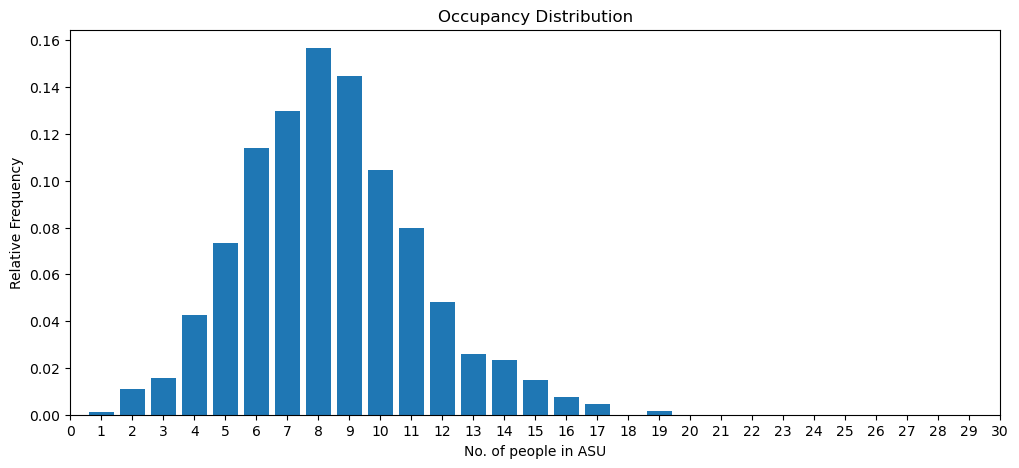

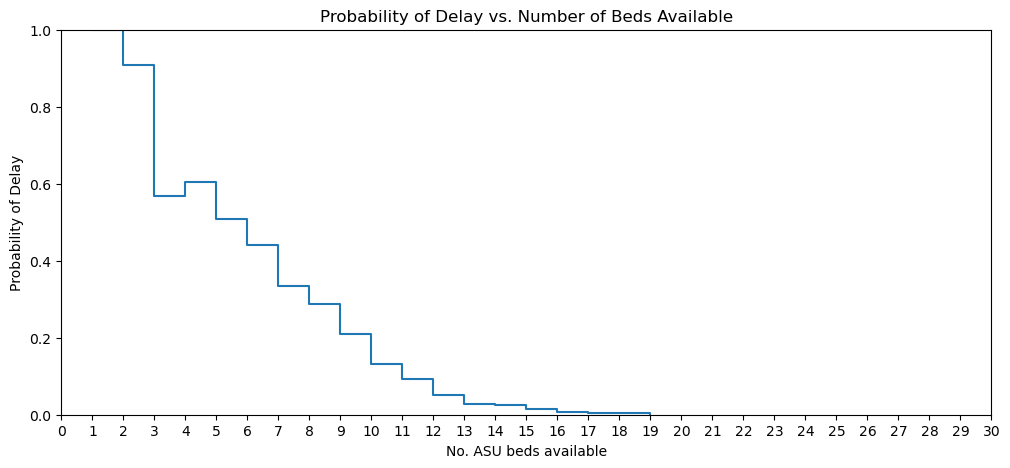


Simulation completed.
Total ASU arrivals: 4530
Final ASU occupancy: 9
Number of occupancy audits: 1825
Average occupancy: 8.38
Maximum occupancy: 19
Minimum occupancy: 1
Simulation time at end of run: 2920
Total Stroke arrivals: 2443
Total TIA arrivals: 324
Total Complex Neurological arrivals: 830
Total Other arrivals: 933


In [80]:
def run_acute_stroke_unit_model():
    # Create the experiment
    experiment = Experiment({
        'results_collection_period': 365*5,  # Run for 5 years
        'trace': False,  # Set to True if you want to see detailed logs
        'acute_audit_interval': 1  # Audit every 1 day
    })

    # Create the simulation environment
    env = simpy.Environment()

    # Create the RehabilitationUnit
    rehab_unit = RehabilitationUnit(env, experiment)

    # Create the AcuteStrokeUnit with the rehab_unit
    asu = AcuteStrokeUnit(env, experiment, rehab_unit)

    # Start the audit process for ASU
    env.process(experiment.audit_acute_occupancy(env, experiment.warm_up, experiment.params['acute_audit_interval'], asu, experiment))

    # Run the model
    asu.run()
    env.run(until=experiment.params['results_collection_period'] + experiment.warm_up)

    # Calculate occupancy frequencies of the ASU occupancy
    rel_freq, cum_freq, unique_vals = calculate_occupancy_frequencies(experiment.asu_occupancy)

    # Display an occupancy plot for the ASU
    fig, ax = occupancy_plot(rel_freq, unique_vals, x_label="No. of people in ASU")
    plt.show()

    # Calculate the probability of delay for ASU
    prob_delay = calculate_prob_delay(rel_freq, cum_freq)

    # Display a probability of delay plot for ASU
    fig, ax = prob_delay_plot(prob_delay, unique_vals, x_label="No. ASU beds available")
    plt.show()

    print("\nSimulation completed.")
    print(f"Total ASU arrivals: {asu.total_arrivals}")
    print(f"Final ASU occupancy: {asu.occupancy}")
    print(f"Number of occupancy audits: {len(experiment.asu_occupancy)}")
    print(f"Average occupancy: {sum(experiment.asu_occupancy) / len(experiment.asu_occupancy):.2f}")
    print(f"Maximum occupancy: {max(experiment.asu_occupancy)}")
    print(f"Minimum occupancy: {min(experiment.asu_occupancy)}")
    print(f"Simulation time at end of run: {env.now}")

    for patient_type in asu.patient_types.values():
        print(f"Total {patient_type.name} arrivals: {patient_type.count}")

if __name__ == "__main__":
    run_acute_stroke_unit_model()


### Script to run the model (Rehab unit only) <a class="anchor" id="iteration_code_b"></a>

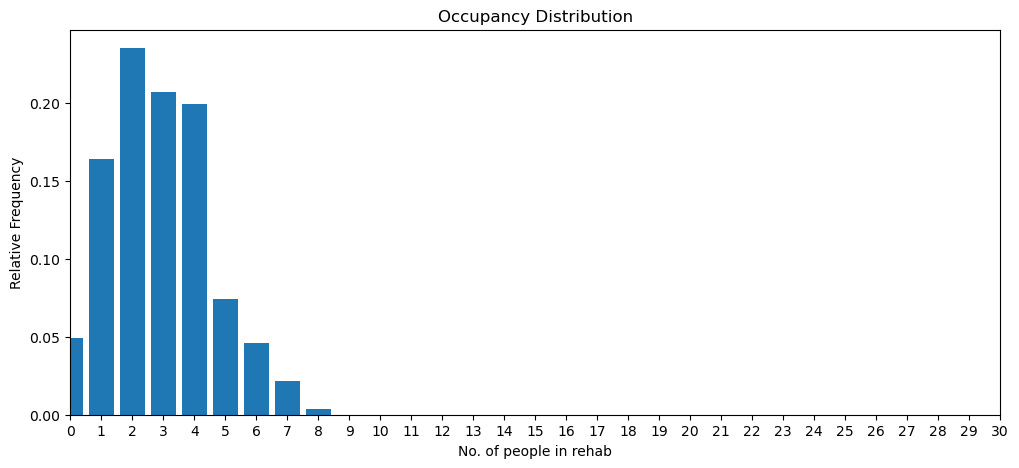

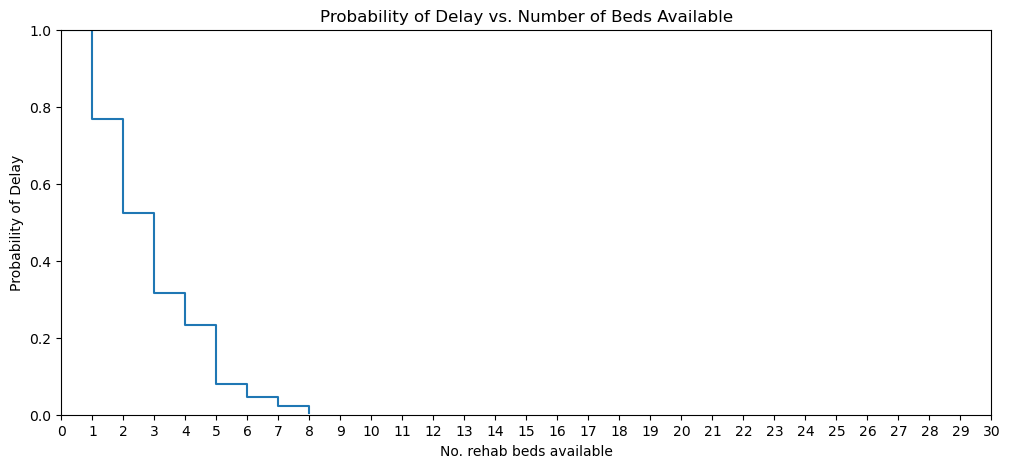


Simulation completed.
Total rehab arrivals: 343
Final rehab patient counts: {'Stroke': 133, 'Complex Neurological': 94, 'Other': 116, 'TIA': 0}


In [81]:
def run_rehabilitation_unit_model():
    experiment = Experiment({
        'results_collection_period': 365*5,
        'trace': False,  # Set to True if you want to see detailed logs
    })
    env = simpy.Environment()
    rehab_unit = RehabilitationUnit(env, experiment)

    # Initialize the audit of rehab occupancy as a SimPy process
    env.process(experiment.audit_rehab_occupancy(env, experiment.warm_up, experiment.params['rehab_audit_interval'], rehab_unit, experiment))

    # Run the model for the results_collection_period + warm_up
    rehab_unit.run()
    env.run(until=experiment.params['results_collection_period'] + experiment.warm_up)

    # Calculate occupancy frequencies of the rehab occupancy
    rel_freq, cum_freq, unique_vals = calculate_occupancy_frequencies(experiment.rehab_occupancy)

    # Display an occupancy plot for the rehab unit
    fig, ax = occupancy_plot(rel_freq, unique_vals, x_label="No. of people in rehab")
    plt.show()

    # Calculate the probability of delay for rehab
    prob_delay = calculate_prob_delay(rel_freq, cum_freq)

    # Display a probability of delay plot for rehab
    fig, ax = prob_delay_plot(prob_delay, unique_vals, x_label="No. rehab beds available")
    plt.show()

    print("\nSimulation completed.")
    print(f"Total rehab arrivals: {rehab_unit.total_arrivals}")
    print(f"Final rehab patient counts: {rehab_unit.patient_counts}")

if __name__ == "__main__":
    run_rehabilitation_unit_model()


## Script to run the model (SYSTEM TEST: ASU+REHAB)

> Modified in iteration 22

In [82]:
def single_run(experiment):
    experiment.reset_kpi()

    # Create the simulation environment
    env = simpy.Environment()

    # Create models
    rehab_unit = RehabilitationUnit(env, experiment)
    asu = AcuteStrokeUnit(env, experiment, rehab_unit)

    # Run models
    rehab_unit.run()
    asu.run()

    # Start the audit processes
    env.process(experiment.audit_acute_occupancy(env, experiment.warm_up, experiment.params['acute_audit_interval'], asu, experiment))
    env.process(experiment.audit_rehab_occupancy(env, experiment.warm_up, experiment.params['rehab_audit_interval'], rehab_unit, experiment))

    # Run the simulation
    env.run(until=experiment.warm_up + experiment.params['results_collection_period'])

    # Calculate occupancy frequencies and probabilities of delay
    rel_freq_a, cum_freq_a, unique_vals_a = calculate_occupancy_frequencies(experiment.asu_occupancy)
    prob_delay_a = calculate_prob_delay(rel_freq_a, cum_freq_a)

    rel_freq_r, cum_freq_r, unique_vals_r = calculate_occupancy_frequencies(experiment.rehab_occupancy)
    prob_delay_r = calculate_prob_delay(rel_freq_r, cum_freq_r)

    return {
        'relative_freq_asu': rel_freq_a,
        'prob_delay_asu': prob_delay_a,
        'unique_vals_asu': unique_vals_a,
        'relative_freq_rehab': rel_freq_r,
        'prob_delay_rehab': prob_delay_r,
        'unique_vals_rehab': unique_vals_r
    }


> The script below was created in iteration 22

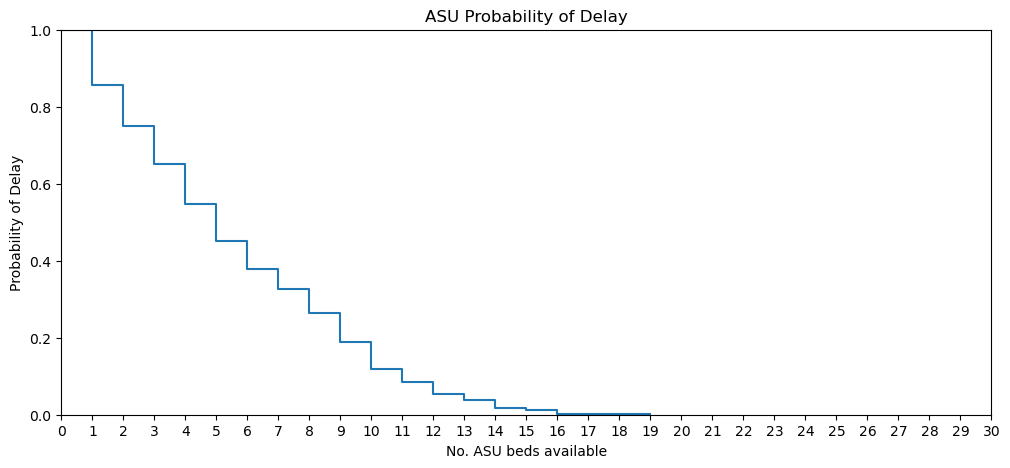

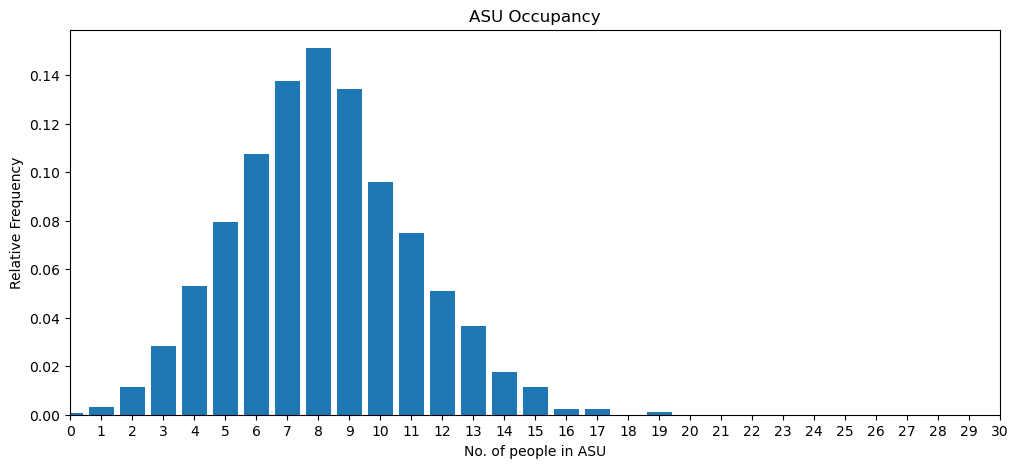

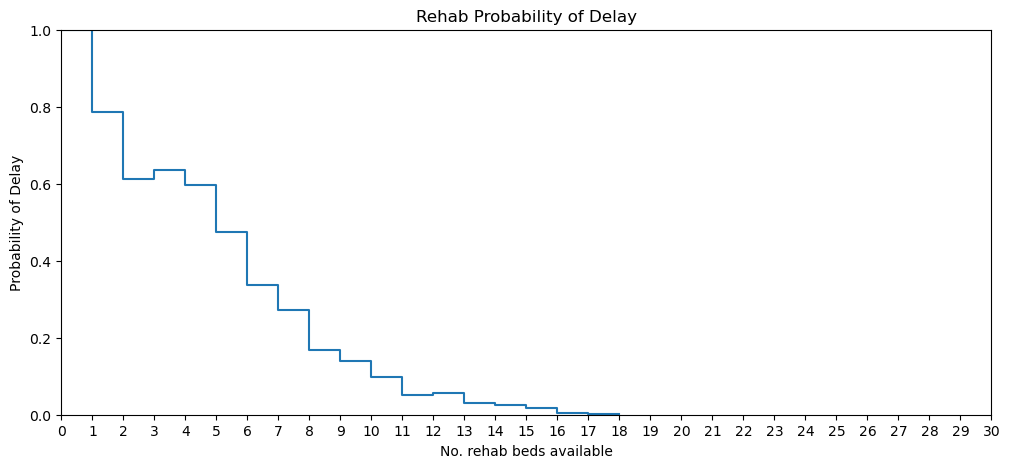

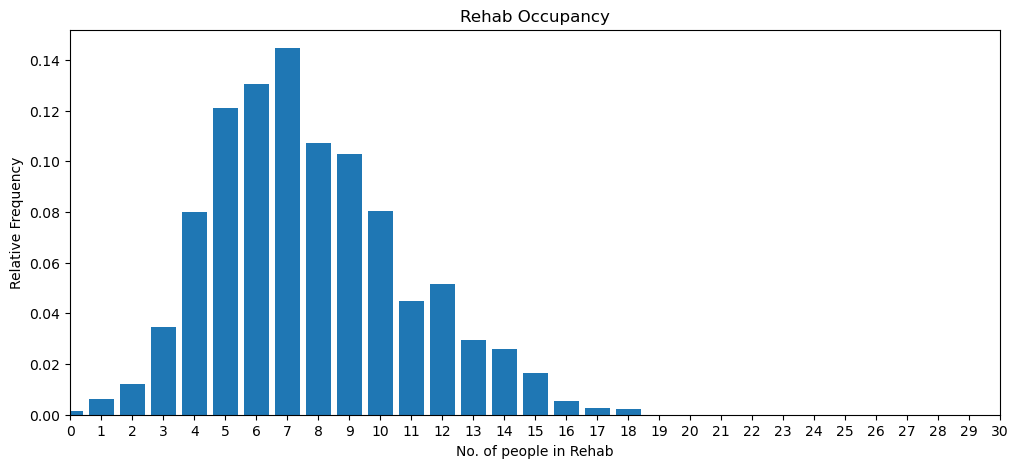


Summary Statistics:
ASU Max Occupancy: 19
ASU Average Occupancy: 8.13
Rehab Max Occupancy: 18
Rehab Average Occupancy: 7.72


In [83]:
def main():
    # Create the experiment
    experiment = Experiment({
        'results_collection_period': 365*5,  # Run for 5 years
        'trace': False,  # Set to True if you want to see detailed logs
    })

    # Run the single run
    results = single_run(experiment)

    # ASU Plots
    # Probability of delay plot for ASU
    fig, ax = prob_delay_plot(results['prob_delay_asu'], results['unique_vals_asu'], x_label="No. ASU beds available")
    plt.title("ASU Probability of Delay")
    plt.show()

    # Occupancy plot for ASU
    fig, ax = occupancy_plot(results['relative_freq_asu'], results['unique_vals_asu'], x_label="No. of people in ASU")
    plt.title("ASU Occupancy")
    plt.show()

    # Rehab Plots
    # Probability of delay plot for Rehab
    fig, ax = prob_delay_plot(results['prob_delay_rehab'], results['unique_vals_rehab'], x_label="No. rehab beds available")
    plt.title("Rehab Probability of Delay")
    plt.show()

    # Occupancy plot for Rehab
    fig, ax = occupancy_plot(results['relative_freq_rehab'], results['unique_vals_rehab'], x_label="No. of people in Rehab")
    plt.title("Rehab Occupancy")
    plt.show()

    # Print some summary statistics
    print("\nSummary Statistics:")
    print(f"ASU Max Occupancy: {max(results['unique_vals_asu'])}")
    print(f"ASU Average Occupancy: {sum(results['relative_freq_asu'] * results['unique_vals_asu']):.2f}")
    print(f"Rehab Max Occupancy: {max(results['unique_vals_rehab'])}")
    print(f"Rehab Average Occupancy: {sum(results['relative_freq_rehab'] * results['unique_vals_rehab']):.2f}")

if __name__ == "__main__":
    main()


## Testing <a class="anchor" id="testing_code"></a>
* **Results processing 1**: code correctly calculates relative and cumulative frequencies
    * Expected result: for [1, 1, 1, 1, 2, 2, 2, 3, 3, 4] relative = [4/10, 3/10, 2/10, 1/10] and cum = [4/10, 7/10, 9/10, 1.0]
    * Actual result (PASS): for [1, 1, 1, 1, 2, 2, 2, 3, 3, 4] relative = [4/10, 3/10, 2/10, 1/10] and cum = [4/10, 7/10, 9/10, 1.0]
* **Results processing 2**: test that prob delay is calculated correctly.
    * Expected result: The probability of delay is [1.0, 0.3/0.7, 0.2/0.9, 0.1/1.0]
    * Actual result (PASS): The probability of delay is [1.0, 0.3/0.7, 0.2/0.9, 0.1/1.0]
* **Results collection test 1**: Test the result collection process for ASU collects ward occupancy every day
    * Expected result: The number of observations taken is 1 less the number of days the model is run.
    * Actual result (PASS):  The number of observations taken is 1 less the number of days the model is run.
* **Results collection test 2**: Test ASU ward occupancy data collected is in a sensible range.
    * Expected result: The type collected is int. The values are in the range 0 to 50 with sensible moments.
    * Actual result (PASS):  The type collected is int. The values are in the range 0 to 50 with sensible moments.
* **Results collection test 3**: Test the result collection process for REHAB collects unit occupancy every day
    * Expected result: The number of observations taken is 1 less the number of days the model is run.
    * Actual result (PASS):  The number of observations taken is 1 less the number of days the model is run.
* **Results collection test 4**: Test REHAB unit occupancy data collected is in a sensible range.
    * Expected result: The type collected is int. The values are in the range 0 to (10-15) with sensible moments.
    * Actual result (PASS):  The type collected is int. The values are 0 to (10-15) with sensible moments.
* **Results collection test 5**: **SYSTEM TEST**: Test the result collection process for ASU+REHAB collects ward occupancy every day
    * Expected result: The number of observations taken is 1 less the number of days the model is run.
    * Actual result (PASS):  The number of observations taken is 1 less the number of days the model is run.
* **Single run test**: **SYSTEM TEST**: Test that the `single_run` function returns a dictionary of results
  * Expected Result: len(run_results) == 6 and type(run_results) == dict
  * Actual Result (PASS): len(run_results) == 6 and type(run_results) == dict
* **Warm-up Period Test**: Test warm-up works correctly for ASU+REHAB ward occupancy. Audit interval = 1 and Warm-up > 0
    * Expected result: The length of the occupancy data collection arrays is equal to the results collection period.
    * Actual result (PASS): The length of the occupancy data collection arrays is equal to the results collection period.
* **Suppress simulated trace**: Test that setting experiment.trace = False suppresses ASU output by default.
    * Expected result: The ASU model runs with no simulated log output
    * Actual result (PASS): The ASU model runs with no simulated log output
* **Suppress simulated trace 2**: Test that setting experiment.trace = False suppresses REHAB output by default.
    * Expected result: The REHAB model runs with no simulated log output
    * Actual result (PASS): The REHAB model runs with no simulated log output
* **Testing lognormal function**: Test that lognomal function correctly calculates the moments of the underlying normal dist.
    * Expected result: The LLM generated function and `sim-tools.distributions.Lognormal` perform the same conversion.
    * Actual results (PASS):  The functions generate the same values.
* **Extreme value test 1**: TIA, Complex Neuro, Other, have their inter-arrival time is set to $M$ a very large number
    * Expected result: The only type of patient to arrive to the model is "Stroke"
    * Actual result (PASS): The only type of patient to arrive to the model is "Stroke"
* **Extreme value test 2**: All patient types have have their inter-arrival time is set to $M$ a very large number
    * Expected result: No patients arrive to the model.
    * Actual result (PASS): No patients arrive to the model.
* **Different run length**: The run length of the model is set to 10 days.
    * Expected result: The model should runs no longer than 10 simulated time periods
    * Actual result (PASS): The model runs no longer than 10 simulated time periods
* **Extreme value test 3**: All patient types have have their mean length of stay time set to $M$ a very large number
    * Expected result: No patients depart the model (only arrivals seen in log)
    * Actual Results (PASS): No patients depart the model.
* **Extreme value test 4**: All patient types apart from stroke->rehab have have their mean length of stay time set to $M$ a very large number
    * Expected result: Only stroke patients depart the model (seen in log)
    * Actual Results (PASS): Only stroke patient depart the model.
* **Extreme value test 5**: In rehab, Complex Neuro, and Other, have their inter-arrival time is set to $M$ a very large number
    * Expected result: The only type of patient to arrive to the rehab model is "Stroke"
    * Actual result (PASS): The only type of patient to arrive to the rehab model is "Stroke"
* **Extreme value test 6**: In the rehab model, all patient types have have their inter-arrival time is set to $M$ a very large number
    * Expected result: No patients arrive to the model.
    * Actual result (PASS): No patients arrive to the model.
* **Extreme value test 7**: In the rehab model, all patient types have their length of stay means set to $M$ a very larger number.
    * Expected result: Patients arrive to the model as normal, but do not depart.
    * Actual result (PASS): Patients arrive to the model as normal, but do not depart.

### Results processing 1

Test that the code correctly calculates the relative and cumulative frequencies of a python list of integer values.

(PASS)

In [19]:
def result_processing_test_1(values, rel_expected, cum_expected):
    '''
    Test the `calculate_occupancy_frequencies` function works
    as expected.

    Expected result: relative frequencies and cumulative freqs
    are the same as expected values.

    Params:
    ------
    values: list
        list of values to test

    rel_expected: list
        list of floats - expected relative freqs

    cum_expected: list
        list of floats - expected cumulative freqs

    Returns:
    -------
    bool: does the model pass the test.
    '''
    rel, cum, unique = calculate_occupancy_frequencies(values)
    # use all close to allow for minor floating point differences.
    return (set(rel) == set(rel_expected)) and  np.allclose(np.array(cum_expected), cum)

In [20]:
result_processing_test_1(values=[1, 1, 1, 1, 2, 2, 2, 3, 3, 4],
                         rel_expected=[0.4, 0.3, 0.2, 0.1],
                         cum_expected=[0.4, 0.7, 0.9, 1.0])

True

### Results Processing test 2

Test that the calculation of the probability of delay is correct.

(PASS)

In [21]:
def result_processing_test_2(relative, cum, p_delay_expected):
    '''
    Test the probability of delay is calculated correctly.
    
    Params:
    ------
    relative: list
        list of floats - relative freqs

    cum: list
        list of floats - cumulative freqs

    Returns:
    -------
    bool: does the function pass the test.
    '''
    p_delay = calculate_prob_delay(relative, cum)
    # use all close to allow for minor floating point differences.
    return np.allclose(np.array(p_delay_expected), p_delay)

In [22]:
relative = [0.4, 0.3, 0.2, 0.1],
cum = [0.4, 0.7, 0.9, 1.0]
expected = [1.0, 0.3/0.7, 0.2/0.9, 0.1/1.0]
result = result_processing_test_2(relative, cum, expected)
result

True

### Results collection test 1

Test the optional results collection process works correctly.  The process should collect acute stroke occupancy every day

(PASS)

In [23]:
def results_collection_test1(audit_interval=1):
    '''
    Test the model collects acute stroke occupancy every day

    Expected result: len(experiment.asu_occupancy) == env.now

    Params:
    ------
    audit_interval: 1
        duration of audit.

    Returns:
    -------
    bool: does the model pass the test.
    '''
    # Create the experiment
    experiment = Experiment({
        'run_length': 365*5,  # Run for 5 years
        'trace': False,  # Set to True if you want to see detailed logs
        'acute_audit_interval': audit_interval  # Audit interval as specified
    })

    # Create the simulation environment
    env = simpy.Environment()

    rehab_unit = RehabilitationUnit(env, experiment)

    # Create the AcuteStrokeUnit
    asu = AcuteStrokeUnit(env, experiment, rehab_unit)

    # modified iteration 21
    # start the audit_acute_occupancy to record ASU occupancy at intervals
    env.process(experiment.audit_acute_occupancy(env, 1, experiment.params['acute_audit_interval'], asu, experiment))

    # Run the model - modified iteration 21
    asu.run()
    env.run(until=experiment.params['results_collection_period'])

    print(f"Number of occupancy audits: {len(experiment.asu_occupancy)}")
    print(f'Simulation time: {env.now}')
    
    # The number of audits should be equal to the simulation time
    # (assuming audit_interval=1 and the first audit happens at time 1)
    return len(experiment.asu_occupancy) == (env.now - 1)


In [24]:
results_collection_test1()

Number of occupancy audits: 1824
Simulation time: 1825


True

### Result collection test 2

(PASS)

In [25]:
def results_collection_test2(audit_interval=1):
    '''
    Test ASU ward occupancy data collected is in a sensible range.
    
    Expected result: The type collected is int. The values are in 
    the range in the range 0 to 50 with sensible moments.

    prints out:
    min
    max
    mean
    deciles

    Params:
    ------
    audit_interval: 1
        duration of audit.

    Returns:
    -------
    None
    '''

    # Create the experiment
    experiment = Experiment({
        'trace': False,
        'acute_audit_interval': audit_interval
    })

    # Create the simulation environment
    env = simpy.Environment()

    rehab_unit = RehabilitationUnit(env, experiment)


    # Create the AcuteStrokeUnit
    asu = AcuteStrokeUnit(env, experiment, rehab_unit)

    # Start the audit process - modified iteration 21
    env.process(experiment.audit_acute_occupancy(env, 1, experiment.params['acute_audit_interval'], asu, experiment))

    # Run the model - modified iteration 21
    asu.run()
    env.run(until=experiment.params['results_collection_period'])

    # Calculate statistics
    min_occupancy = min(experiment.asu_occupancy)
    max_occupancy = max(experiment.asu_occupancy)
    mean_occupancy = statistics.fmean(experiment.asu_occupancy)
    deciles = [round(q, 1) for q in statistics.quantiles(experiment.asu_occupancy, n=10)]

    # Print results
    print(f'Minimum occupancy: {min_occupancy}')
    print(f'Maximum occupancy: {max_occupancy}')
    print(f'Mean occupancy: {mean_occupancy:.2f}')
    print(f'Deciles of occupancy: {deciles}')


In [26]:
results_collection_test2()

Minimum occupancy: 1
Maximum occupancy: 18
Mean occupancy: 7.84
Deciles of occupancy: [4.0, 5.0, 6.0, 7.0, 8.0, 8.0, 9.0, 10.0, 12.0]


### Results collection test 3

Test the optional results collection process works correctly for rehab.  The process should collect rehab unit occupancy every day.

(PASS)


In [27]:
def results_collection_test3(audit_interval=1):
    '''
    Test the model collects rehab occupancy every day

    Expected result: len(experiment.rehab_occupancy) == env.now - 1

    Params:
    ------
    audit_interval: 1
        duration of audit.

    Returns:
    -------
    bool: does the model pass the test.
    '''
    # Create the simulation environment
    env = simpy.Environment()

    # create experiment
    experiment = Experiment()
    
    rehab_unit = RehabilitationUnit(env, experiment)

    # Start the audit process - modified iteration 21
    env.process(experiment.audit_rehab_occupancy(env, 1, experiment.params['rehab_audit_interval'], rehab_unit, experiment))
    
    # Run the model for the default run length in the experiment - modified in iteration 21
    env.run(until=experiment.params['results_collection_period'])
    
    print(f'{len(experiment.rehab_occupancy)=}')
    print(f'{env.now=}')
    return len(experiment.rehab_occupancy) == (env.now - 1)

In [28]:
results_collection_test3()

len(experiment.rehab_occupancy)=1824
env.now=1825


True

## Results Collection Test 4

(PASS)

In [29]:
def results_collection_test4(audit_interval=1):
    '''
    Test REHAB ward occupancy data collected is in a sensible range.
    
    Expected result: The type collected is int. The values are in 
    the range 1 to [10-15] with sensible moments.

    Note this is when the Rehab unit is used independently
    with external arrivals only i.e. no transfers from ASU.

    prints out:
    min
    max
    mean
    deciles

    Params:
    ------
    audit_interval: 1
        duration of audit.

    Returns:
    -------
    None
    '''
    # Create the simulation environment
    env = simpy.Environment()
    
    # create experiment
    experiment = Experiment()
    
    rehab_unit = RehabilitationUnit(env, experiment)
    rehab_unit.run()
    
    # Start the audit process - modified iteration 21
    env.process(experiment.audit_rehab_occupancy(env, 1, experiment.params['rehab_audit_interval'], rehab_unit, experiment))
    
    # Run the model for the default run length in the experiment - modified in iteration 21
    env.run(until=experiment.params['results_collection_period'])
    
    print(f'min(experiment.rehab_occupancy)={min(experiment.rehab_occupancy)}')
    print(f'max(experiment.rehab_occupancy)={max(experiment.rehab_occupancy)}')
    print(f'statistics.fmean(experiment.rehab_occupancy)={statistics.fmean(experiment.rehab_occupancy):.2f}')
    print('Deciles:', [round(q, 1) for q in statistics.quantiles(experiment.rehab_occupancy, n=10)])


In [30]:
results_collection_test4()

min(experiment.rehab_occupancy)=0
max(experiment.rehab_occupancy)=9
statistics.fmean(experiment.rehab_occupancy)=2.87
Deciles: [1.0, 1.0, 2.0, 2.0, 3.0, 3.0, 4.0, 5.0, 5.0]


### Results Collection Test 5 (SYSTEM TEST)

Test that when the models are linked that the occupancy is audited correctly.

In [31]:
def results_collection_test5(audit_interval=1):
    '''
    Test REHAB ward occupancy data collected is in a sensible range
    when it is connected to the ASU model.
    
    Expected result: The type collected is int. The values are in 
    the range in the range 1 to [10-15] with sensible moments.

    Expected result: 
        len(experiment.asu_occupancy) == env.now - 1 AND
        len(experiment.rehab_occupancy) == env.now - 1

    Params:
    ------
    audit_interval: 1
        duration of audit.

    Returns:
    -------
    bool: does the model pass the test.
    '''
    # Create the simulation environment
    env = simpy.Environment()
    
    # Create an experiment with default parameters
    experiment = Experiment()

    # Create models
    rehab_unit = RehabilitationUnit(env, experiment)
    asu = AcuteStrokeUnit(env, experiment, rehab_unit)
    
    # Start the ASU patient generators for each type of patient
    asu.run()
    rehab_unit.run()

    # Start the audit process - modified iteration 21
    env.process(experiment.audit_rehab_occupancy(env, 1, experiment.params['rehab_audit_interval'], rehab_unit, experiment))
    env.process(experiment.audit_acute_occupancy(env, 1, experiment.params['acute_audit_interval'], asu, experiment))
    
    # Run the simulation until the specified run length in the Experiment parameters - modified in iteration 21
    env.run(until=experiment.params['results_collection_period'])

    # Print info for debug
    print(f"Average rehab occupancy: {sum(experiment.rehab_occupancy) / len(experiment.rehab_occupancy):.2f}")
    print(f"Maximum rehab occupancy: {max(experiment.rehab_occupancy)}")
    print(f"Minimum rehab occupancy: {min(experiment.rehab_occupancy)}")
    print(f'{len(experiment.asu_occupancy)=}')
    print(f'{len(experiment.rehab_occupancy)=}')
    print(f'{env.now=}')

    # Test
    return len(experiment.asu_occupancy) == (env.now - 1) and \
           len(experiment.rehab_occupancy) == (env.now - 1)


In [32]:
results_collection_test5()

Average rehab occupancy: 6.20
Maximum rehab occupancy: 13
Minimum rehab occupancy: 0
len(experiment.asu_occupancy)=1824
len(experiment.rehab_occupancy)=1824
env.now=1825


True

### Results Collection Test 6 (SYSTEM TEST)


In [33]:
def results_collection_test6(audit_interval=1):
    '''
    Test the model collects acute stroke occupancy every day

    Expected result: The type collected is int. The values are in 
    the range in the range 1 to ~25 with sensible moments.

    Note this is when the Rehab unit is linked to the ASU.
    I.e. transfers from ASU + external arrivals

    prints out:
    min
    max
    mean
    deciles

    Params:
    ------
    audit_interval: 1
        duration of audit.

    Returns:
    -------
    bool: does the model pass the test.
    '''
    # Create the simulation environment
    env = simpy.Environment()
    
    # Create an experiment with default parameters
    experiment = Experiment()

    # Create models
    rehab_unit = RehabilitationUnit(env, experiment)
    asu = AcuteStrokeUnit(env, experiment, rehab_unit)
    
    # Start the ASU patient generators for each type of patient
    asu.run()
    rehab_unit.run()

    # Start the audit process - modified iteration 21
    env.process(experiment.audit_rehab_occupancy(env, 1, experiment.params['rehab_audit_interval'], rehab_unit, experiment))
    env.process(experiment.audit_acute_occupancy(env, 1, experiment.params['acute_audit_interval'], asu, experiment))
    
    # Run the simulation until the specified run length in the Experiment parameters - modified in iteration 21
    env.run(until=experiment.params['results_collection_period'])

    # Test
    print(f'min(experiment.rehab_occupancy)={min(experiment.rehab_occupancy)}')
    print(f'max(experiment.rehab_occupancy)={max(experiment.rehab_occupancy)}')
    print(f'statistics.fmean(experiment.rehab_occupancy)={statistics.fmean(experiment.rehab_occupancy):.2f}')
    print('Deciles:', [round(q, 1) for q in statistics.quantiles(experiment.rehab_occupancy, n=10)])



In [34]:
results_collection_test6()

min(experiment.rehab_occupancy)=0
max(experiment.rehab_occupancy)=15
statistics.fmean(experiment.rehab_occupancy)=6.46
Deciles: [3.0, 4.0, 5.0, 5.0, 6.0, 7.0, 8.0, 9.0, 11.0]


### Warm-up Test

(PASS)

In [35]:
def warm_up_test(warm_up, audit_interval=1):
    '''
    Test warm-up works correctly for ASU+REHAB ward occupancy

    Expected result: 
        len(experiment.asu_occupancy) == experiment.params['results_collection_period'] 
        AND len(experiment.rehab_occupancy) == experiment.params['results_collection_period'] 

    Params:
    ------
    warm_up: int
        Duration of warm-up period.
    audit_interval: int, default 1
        Duration of audit interval.

    Returns:
    -------
    bool: does the model pass the test.
    '''
    # Create the experiment with specified warm-up period
    experiment = Experiment({
        'warm_up': warm_up,
        'acute_audit_interval': audit_interval,
        'rehab_audit_interval': audit_interval
    })

    # Create the simulation environment
    env = simpy.Environment()
    
    # Create models
    rehab_unit = RehabilitationUnit(env, experiment)
    asu = AcuteStrokeUnit(env, experiment, rehab_unit)
    
    # Start the ASU patient generators
    asu.run()

    # Start the REHAB patient generators
    rehab_unit.run()

    # Start the audit processes
    env.process(experiment.audit_acute_occupancy(env, experiment.warm_up, audit_interval, asu, experiment))
    env.process(experiment.audit_rehab_occupancy(env, experiment.warm_up, audit_interval, rehab_unit, experiment))
    
    # Run the simulation
    env.run(until=experiment.warm_up + experiment.params['results_collection_period'])

    # Print info for debug
    print(f'{len(experiment.asu_occupancy)=}')
    print(f'{len(experiment.rehab_occupancy)=}')
    print(f'{env.now=}')
    print(f'{experiment.params["results_collection_period"]=}')
    print(f'{experiment.warm_up + experiment.params["results_collection_period"]=}')

    # Test
    return (len(experiment.asu_occupancy) == experiment.params['results_collection_period'] and 
            len(experiment.rehab_occupancy) == experiment.params['results_collection_period'])


In [36]:
warm_up_test(warm_up=365)

len(experiment.asu_occupancy)=1825
len(experiment.rehab_occupancy)=1825
env.now=2190
experiment.params["results_collection_period"]=1825
experiment.warm_up + experiment.params["results_collection_period"]=2190


True

### Single run test (SYSTEM TEST)

In [39]:
def single_run_test():
    '''
    Test the single_run function returns a dictionary of 
    results.

    The results dictionary contains the following keys:

    'relative_freq_asu'
    'prob_delay_asu'
    'unique_vals_asu'
    'relative_freq_rehab'
    'prob_delay_rehab'
    'unique_vals_rehab'

    Expected result: 
        len(run_results) == 6 and type(run_results) == dict

    Returns:
    -------
    bool: does the model pass the test.
    '''

    # a default experiment
    default_experiment_params = Experiment()

    # run the model
    run_results = single_run(default_experiment_params)

    # Print the results for debugging
    print(f"{run_results['relative_freq_asu']=}")
    print(f"{run_results['prob_delay_asu']=}")
    print(f"{run_results['unique_vals_asu']=}")
    print(f"{run_results['relative_freq_rehab']=}")
    print(f"{run_results['prob_delay_rehab']=}")
    print(f"{run_results['unique_vals_rehab']=}")

    # Test
    expected_keys = {
        'relative_freq_asu',
        'prob_delay_asu',
        'unique_vals_asu',
        'relative_freq_rehab',
        'prob_delay_rehab',
        'unique_vals_rehab'
    }

    return len(run_results) == 6 and type(run_results) == dict and set(run_results.keys()) == expected_keys


In [40]:
single_run_test()

run_results['relative_freq_asu']=array([0.00054795, 0.00931507, 0.02575342, 0.05589041, 0.09205479,
       0.13150685, 0.1090411 , 0.14191781, 0.12438356, 0.09260274,
       0.0860274 , 0.05589041, 0.04054795, 0.01808219, 0.01260274,
       0.00383562])
run_results['prob_delay_asu']=array([1.        , 0.94444444, 0.72307692, 0.61077844, 0.50149254,
       0.4173913 , 0.25710594, 0.25072604, 0.18015873, 0.11826452,
       0.09899117, 0.06042654, 0.04199773, 0.0183844 , 0.01265127,
       0.00383562])
run_results['unique_vals_asu']=array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])
run_results['relative_freq_rehab']=array([0.00109589, 0.01150685, 0.03232877, 0.06082192, 0.11123288,
       0.14246575, 0.15671233, 0.13643836, 0.13369863, 0.09589041,
       0.06410959, 0.02958904, 0.01479452, 0.00712329, 0.00164384,
       0.00054795])
run_results['prob_delay_rehab']=array([1.00000000e+00, 9.13043478e-01, 7.19512195e-01, 5.75129534e-01,
       5.12626263e-01, 3.96341463

True

## Test suppress trace 1

(PASS)

In [43]:
def test_suppress_log(trace):
    '''
    Test that setting experiment.trace 
    False suppresses output.

    Expected result: patient_count > 0

    Params:
    ------
    trace: bool
        is trace outputted or not?

    Returns:
    -------
    int: number of patient arrivals.
    '''

    experiment = Experiment({'trace': trace})
    env = simpy.Environment()
    rehab_unit = RehabilitationUnit(env, experiment)
    model = AcuteStrokeUnit(env, experiment, rehab_unit)
    model.run()
    env.run(until=experiment.params['results_collection_period'])
    
    print("\nSimulation completed.")
    print(f"Total simulation time: {model.env.now:.2f} days")
    print(f"Total patient arrivals: {model.total_arrivals}")
    for patient_type in model.patient_types.values():
        print(f"Total {patient_type.name} arrivals: {patient_type.count}")



In [44]:
test_suppress_log(trace=False)


Simulation completed.
Total simulation time: 1825.00 days
Total patient arrivals: 2879
Total Stroke arrivals: 1535
Total TIA arrivals: 197
Total Complex Neurological arrivals: 544
Total Other arrivals: 603


### Test suppress trace 2

In [45]:
def test_suppress_log_rehab(trace):
    '''
    Test that setting experiment.trace to
    False suppresses output in the rehab model

    Expected result: patient_count > 0

    Params:
    ------
    trace: bool
        is trace outputted or not?

    Returns:
    -------
    int: number of patient arrivals.
    '''
    # Create the simulation environment


    experiment = Experiment({'trace': trace})
    env = simpy.Environment()
    model = RehabilitationUnit(env, experiment)
    asu = AcuteStrokeUnit(env, experiment, model)
    model.run()
    env.run(until=experiment.params['results_collection_period'])
    
    print("\nSimulation completed.")
    print(f"Total simulation time: {model.env.now:.2f} days")
    print(f"Total patient arrivals: {model.total_arrivals}")
    print(f"Final rehab patient counts: {model.patient_counts}")


In [46]:
test_suppress_log_rehab(False)


Simulation completed.
Total simulation time: 1825.00 days
Total patient arrivals: 189
Final rehab patient counts: {'Stroke': 76, 'Complex Neurological': 52, 'Other': 61, 'TIA': 0}


### Lognormal test

Test that lognomal function correctly calculates the moments of the underlying normal dist.

**Result: PASS**

In [49]:
def test_lognormal_moments(mean, std):
    '''
    Test that lognomal function correctly calculates 
    the moments of the underlying normal dist.

    Params:
    ------
    mean: float
        mean of the lognormal distribution

    std: float
        st dev of the lognormal distribution

    Returns:
    -------
    bool
    '''
   
    # Lognormal class from sim-tools.
    expected_moments = Lognormal(mean, std)
    print(expected_moments.mu, expected_moments.sigma)

    # Convert lognormal parameters from llm for asu
    normal_mean = math.log(mean**2 / math.sqrt(std**2 + mean**2))
    normal_std = math.sqrt(math.log(1 + (std**2 / mean**2)))
    print(normal_mean, normal_std)

    # Check lognormal calculations from llm used in rehab model
    rehab_mean = np.log(mean**2 / np.sqrt(std**2 + mean**2)) 
    rehab_std = np.sqrt(np.log(1 + (std**2 / mean**2)))
    print (rehab_mean, rehab_std)


    return (normal_mean, normal_std) == (expected_moments.mu, expected_moments.sigma) == (rehab_mean, rehab_std)

In [50]:
test_lognormal_moments(128.79, 267.51)

4.022977459259615 1.2924439729790718
4.022977459259615 1.2924439729790718
4.022977459259615 1.2924439729790718


True

### Extreme value test 1

The model uses hard coded parameters.  The most simple way to modify the code for this test was to change hard coded parameters for $M$

**Result: PASS**

In [51]:
M = 10_000_000

In [52]:
def ev_test_1(large_number):
    '''
    TIA, Complex Neuro, Other, have their inter-arrival 
    time set to $M$ a very large number
    
    Expected result: The only type of patient to arrive to the model 
    is "Stroke". This is seen in the event log

    Params:
    -------
    large_number: int
        M a very large number 

    Returns:
    --------
    int: the number of patients that arrived to the model.
    '''

    def main(arrival_rates=None, results_collection_period=None):
        custom_params = {}
        
        if arrival_rates:
            custom_params['patient_types'] = arrival_rates
        
        if results_collection_period:
            custom_params['results_collection_period'] = results_collection_period
    
        # Create an Experiment instance with custom parameters
        experiment = Experiment(custom_params)
    
        # Run the simulation with the custom experiment
        env = simpy.Environment()
        rehab_unit = RehabilitationUnit(env, experiment)
        model = AcuteStrokeUnit(env, experiment, rehab_unit)
        model.run()
        env.run(until=experiment.params['results_collection_period'])
    
        # Print results to check
        print("\nSimulation completed.")
        print(f"Total simulation time: {model.env.now:.2f} days")
        print(f"Total patient arrivals: {model.total_arrivals}")
        for patient_type in model.patient_types.values():
            print(f"Total {patient_type.name} arrivals: {patient_type.count}")
    
    if __name__ == "__main__":
        large_number = M
        
        asu_arrival_rates = {
            'Stroke': {'interarrival_time': 1.2},
            'TIA': {'interarrival_time': large_number},
            'Complex Neurological': {'interarrival_time': large_number},
            'Other': {'interarrival_time': large_number}
        }
    
    main(asu_arrival_rates, results_collection_period=2*365)  # Run for 2 years with custom parameters


In [53]:
ev_test_1(M)


Simulation completed.
Total simulation time: 730.00 days
Total patient arrivals: 630
Total Stroke arrivals: 630
Total TIA arrivals: 0
Total Complex Neurological arrivals: 0
Total Other arrivals: 0


### Extreme value test 2

* An experiment is setup so that all patient types have a mean inter-arrival rate of $M$

**Result: PASS**

In [54]:
def ev_test_2(large_number):
    '''
    All patient types have have their inter-arrival time is 
    set to $M$ a very large number
    
    Expected result: No patients arrive to the model.
    
    Params:
    -------
    large_number: int
        M a very large number 

    Returns:
    --------
    int: the number of patients that arrived to the model.
    '''

    def main(arrival_rates=None, results_collection_period=None):
        custom_params = {}
        
        if arrival_rates:
            custom_params['patient_types'] = arrival_rates
        
        if results_collection_period:
            custom_params['results_collection_period'] = results_collection_period
    
        # Create an Experiment instance with custom parameters
        experiment = Experiment(custom_params)
    
        # Run the simulation with the custom experiment
        env = simpy.Environment()
        rehab_unit = RehabilitationUnit(env, experiment)
        model = AcuteStrokeUnit(env, experiment, rehab_unit)
        model.run()
        env.run(until=experiment.params['results_collection_period'])
    
        # Print results to check
        print("\nSimulation completed.")
        print(f"Total simulation time: {model.env.now:.2f} days")
        print(f"Total patient arrivals: {model.total_arrivals}")
        for patient_type in model.patient_types.values():
            print(f"Total {patient_type.name} arrivals: {patient_type.count}")
    
    if __name__ == "__main__":
        large_number = M
        
        asu_arrival_rates = {
            'Stroke': {'interarrival_time': large_number},
            'TIA': {'interarrival_time': large_number},
            'Complex Neurological': {'interarrival_time': large_number},
            'Other': {'interarrival_time': large_number}
        }
    
    main(asu_arrival_rates, results_collection_period=2*365)  # Run for 2 years with custom parameters


In [55]:
ev_test_2(M)


Simulation completed.
Total simulation time: 730.00 days
Total patient arrivals: 0
Total Stroke arrivals: 0
Total TIA arrivals: 0
Total Complex Neurological arrivals: 0
Total Other arrivals: 0


### Different run length test

The model has again been modified to use the original code and parameters generated by the LLM.

In [56]:
TEN_DAYS = 10

In [57]:
def test_run_length(results_collection_period):
    '''
    Test that the run length of the model can be modified.
    
    Expected result: The model should runs no longer than the new run length.

    Params:
    ------
    run_length: float
        Run length of the model in days.

    Returns:
    -------
    float
        Simulation end time.
    '''
    def main(results_collection_period=None):
        custom_params = {}
        
        if results_collection_period:
            custom_params['results_collection_period'] = results_collection_period
    
        # Create an Experiment instance with custom parameters
        experiment = Experiment(custom_params)

        # Run the simulation with the custom experiment
        env = simpy.Environment()
        rehab_unit = RehabilitationUnit(env, experiment)
        model = AcuteStrokeUnit(env, experiment, rehab_unit)
        model.run()
        env.run(until=experiment.params['results_collection_period'])
    
        # Print results to check
        print("\nSimulation completed.")
        print(f"Total simulation time: {model.env.now:.2f} days")
        print(f"Total patient arrivals: {model.total_arrivals}")
        for patient_type in model.patient_types.values():
            print(f"Total {patient_type.name} arrivals: {patient_type.count}")
    if __name__ == "__main__":
        main(results_collection_period=results_collection_period)


In [58]:
test_run_length(TEN_DAYS)


Simulation completed.
Total simulation time: 10.00 days
Total patient arrivals: 19
Total Stroke arrivals: 12
Total TIA arrivals: 0
Total Complex Neurological arrivals: 1
Total Other arrivals: 6


### Extreme value test 3

* An experiment is setup so that all patient types have a mean length of stay on the ASU of $M$

**Result: PASS**

In [59]:
def ev_test_3(large_number):
    '''
    All patient types have have their mean length 
    of stay time set to $M$ a very large number
    
    Expected result: No patients depart the model 
    (only arrivals seen in log)

    Params:
    -------
    large_number: int
        M a very large number 
    '''
    def main(los_params=None, results_collection_period=None, trace=True):
        custom_params = {'patient_types': {}}
        
        if los_params:
            for patient_type, los in los_params.items():
                if patient_type not in custom_params['patient_types']:
                    custom_params['patient_types'][patient_type] = {}
                custom_params['patient_types'][patient_type]['los_params'] = los
        
        if results_collection_period:
            custom_params['results_collection_period'] = results_collection_period

        
        if trace:
            custom_params['trace'] = True
            
        # Create an Experiment instance with custom parameters
        experiment = Experiment(custom_params)
    
        # Run the simulation with the custom experiment
        env = simpy.Environment()
        rehab_unit = RehabilitationUnit(env, experiment)
        model = AcuteStrokeUnit(env, experiment, rehab_unit)
        model.run()
        env.run(until=experiment.params['results_collection_period'])
    
        # Print results
        print("\nSimulation completed.")
        print(f"Total simulation time: {model.env.now:.2f} days")
        print(f"Total patient arrivals: {model.total_arrivals}")
        print(f"Total occupancy: {model.occupancy}")
        for patient_type in model.patient_types.values():
            print(f"Total {patient_type.name} arrivals: {patient_type.count}")

        return model  # Return the model so we can access its attributes

    # New length of stay parameters - stdev is default
    new_los_params = {
        'Stroke': {'Rehab': (large_number, 8.6), 'ESD': (large_number, 4.8), 'Other': (large_number, 8.7)},
        'TIA': (large_number, 5.0),
        'Complex Neurological': (large_number, 5.0),
        'Other': (large_number, 5.2)
    }

    # Run the simulation with new parameters
    model = main(los_params=new_los_params, results_collection_period=2*365)

    # Check if the total number of arrivals is greater than the final occupancy
    total_arrivals = model.total_arrivals
    final_occupancy = model.occupancy

    return total_arrivals == final_occupancy

In [60]:
result = ev_test_3(M)

Time 0.27: Patient 0 (Complex Neurological) arrived
 Total arrivals: 1
 Complex Neurological arrivals: 1
 Post-ASU destination: Rehab
 Next Complex Neurological arrival in 0.27 days
 Current occupancy: 1
Time 0.27: Patient 0 (Complex Neurological) starting acute treatment
 Length of stay: 9999988.59 days
Time 2.00: Patient 1 (Stroke) arrived
 Total arrivals: 2
 Stroke arrivals: 1
 Post-ASU destination: Rehab
 Next Stroke arrival in 2.00 days
 Current occupancy: 2
Time 2.00: Patient 1 (Stroke) starting acute treatment
 Length of stay: 10000010.41 days
Time 2.15: Patient 2 (Stroke) arrived
 Total arrivals: 3
 Stroke arrivals: 2
 Post-ASU destination: ESD
 Next Stroke arrival in 0.14 days
 Current occupancy: 3
Time 2.15: Patient 2 (Stroke) starting acute treatment
 Length of stay: 10000002.07 days
Time 2.56: Patient 3 (Stroke) arrived
 Total arrivals: 4
 Stroke arrivals: 3
 Post-ASU destination: Other
 Next Stroke arrival in 0.41 days
 Current occupancy: 4
Time 2.56: Patient 3 (Stroke) st

In [55]:
result

True

### Extreme value test 4

* An experiment is setup so that all patient types other than stroke->rehab have a mean length of stay on the ASU of $M$

**Result: PASS**

In [61]:
def ev_test_4(large_number):
    '''
    All patient types apart from stroke-rehab patients
    have have their mean length 
    of stay time set to $M$ a very large number
    
    Expected result: Only stroke patients depart the
    model.
    (only arrivals seen in log)

    Params:
    -------
    large_number: int
        M a very large number 
    '''
    
    def main(los_params=None, results_collection_period=None, trace=True):
        custom_params = {'patient_types': {}}
        
        if los_params:
            for patient_type, los in los_params.items():
                if patient_type not in custom_params['patient_types']:
                    custom_params['patient_types'][patient_type] = {}
                custom_params['patient_types'][patient_type]['los_params'] = los
        
        if results_collection_period:
            custom_params['results_collection_period'] = results_collection_period

        if trace:
            custom_params['trace'] = True
    
        # Create an Experiment instance with custom parameters
        experiment = Experiment(custom_params)
    
        # Run the simulation with the custom experiment
        env = simpy.Environment()
        rehab_unit = RehabilitationUnit(env, experiment)
        model = AcuteStrokeUnit(env, experiment, rehab_unit)
        model.run()
        env.run(until=experiment.params['results_collection_period'])
    
        # Print results
        print("\nSimulation completed.")
        print(f"Total simulation time: {model.env.now:.2f} days")
        print(f"Total patient arrivals: {model.total_arrivals}")
        print(f"Total occupancy: {model.occupancy}")
        for patient_type in model.patient_types.values():
            print(f"Total {patient_type.name} arrivals: {patient_type.count}")

        return model  # Return the model so we can access its attributes

    # New length of stay parameters - stdev is default
    new_los_params = {
        'Stroke': {'Rehab': (7.4, 8.6), 'ESD': (large_number, 4.8), 'Other': (large_number, 8.7)},
        'TIA': (large_number, 5.0),
        'Complex Neurological': (large_number, 5.0),
        'Other': (large_number, 5.2)
    }

    # Run the simulation with new parameters
    model = main(los_params=new_los_params, results_collection_period=2*365)

    # Check if the total number of arrivals is greater than the final occupancy
    total_arrivals = model.total_arrivals
    final_occupancy = model.occupancy

    return total_arrivals > final_occupancy


In [62]:
results = ev_test_4(M)

Time 0.39: Patient 0 (Stroke) arrived
 Total arrivals: 1
 Stroke arrivals: 1
 Post-ASU destination: Rehab
 Next Stroke arrival in 0.39 days
 Current occupancy: 1
Time 0.39: Patient 0 (Stroke) starting acute treatment
 Length of stay: 49.60 days
Time 1.41: Patient 1 (Stroke) arrived
 Total arrivals: 2
 Stroke arrivals: 2
 Post-ASU destination: Other
 Next Stroke arrival in 1.02 days
 Current occupancy: 2
Time 1.41: Patient 1 (Stroke) starting acute treatment
 Length of stay: 9999995.99 days
Time 1.43: Patient 2 (Stroke) arrived
 Total arrivals: 3
 Stroke arrivals: 3
 Post-ASU destination: Other
 Next Stroke arrival in 0.01 days
 Current occupancy: 3
Time 1.43: Patient 2 (Stroke) starting acute treatment
 Length of stay: 9999988.15 days
Time 1.56: Patient 3 (Other) arrived
 Total arrivals: 4
 Other arrivals: 1
 Post-ASU destination: Other
 Next Other arrival in 1.56 days
 Current occupancy: 4
Time 1.56: Patient 3 (Other) starting acute treatment
 Length of stay: 10000001.29 days
Time 1.6

In [58]:
results

True

### Extreme value test 5

Only stroke arrivals to the Rehab unit

(PASS)

In [63]:
def ev_test_5(large_number):
    '''
    Complex Neuro, Other, have their rehab inter-arrival 
    time is set to $M$ a very large number
    
    Expected result: The only type of patient to arrive to the rehab model 
    is "Stroke". This is verified by the patient counts variables in the model.

    Notes:
    ------
    This test will need to be modified when the hardcoded parameters
    are migrated to the Experiment class. 

    Params:
    -------
    large_number: int
        M a very large number 

    Returns:
    --------
    bool: rehab_unit.stroke_count == rehab_unit.patient_count
    
    '''

    # Create the simulation environment
    experiment = Experiment({
        'trace': False,  # Set to True if you want to see detailed logs
        'rehab_stroke_iat': 21.8,
        'rehab_neuro_iat': large_number,
        'rehab_other_iat': large_number
    })
    env = simpy.Environment()
    rehab_unit = RehabilitationUnit(env, experiment)
    rehab_unit.run()
    env.run(until=experiment.params['results_collection_period'])

    # Print out stats collected
    print(f"Patient counts:")
    for patient_type, count in rehab_unit.patient_counts.items():
        print(f"  {patient_type}: {count}")

    print(f"Total arrivals: {rehab_unit.total_arrivals}")
    
    # Check if only Stroke patients arrived
    return rehab_unit.patient_counts['Stroke'] == rehab_unit.total_arrivals

    print(f"Total arrivals: {rehab_unit.total_arrivals}")


In [64]:
ev_test_5(M)

Patient counts:
  Stroke: 79
  Complex Neurological: 0
  Other: 0
  TIA: 0
Total arrivals: 79


True

### Extreme Value test 6

No arrivals to the rehab unit.

(PASS)

In [65]:
def ev_test_6(large_number):
    '''
    All patients have their rehab inter-arrival 
    time is set to $M$ a very large number
    
    Expected result: No patients will arrive in the model

    Notes:
    ------
    This test will need to be modified when the hardcoded parameters
    are migrated to the Experiment class. 

    Params:
    -------
    large_number: int
        M a very large number 

    Returns:
    --------
    bool: rehab_unit.stroke_count == rehab_unit.patient_count
    
    '''

    # Create the simulation environment
    experiment = Experiment({
        'trace': True,  # Set to True if you want to see detailed logs
        'rehab_stroke_iat': large_number,
        'rehab_neuro_iat': large_number,
        'rehab_other_iat': large_number
    })
    env = simpy.Environment()
    rehab_unit = RehabilitationUnit(env, experiment)
    rehab_unit.run()
    env.run(until=experiment.params['results_collection_period'])

    # Print out stats collected
    print(f"Patient counts:")
    for patient_type, count in rehab_unit.patient_counts.items():
        print(f"  {patient_type}: {count}")

    print(f"Total arrivals: {rehab_unit.total_arrivals}")
    
    print(f"Total arrivals: {rehab_unit.total_arrivals}")


In [66]:
ev_test_6(M)

Patient counts:
  Stroke: 0
  Complex Neurological: 0
  Other: 0
  TIA: 0
Total arrivals: 0
Total arrivals: 0


### Extreme value test 7

In the rehab model, all patient types have their length of stay means set to $M$ a very larger number.

(PASS)

In [67]:
def ev_test_7(large_number):
    '''
    All patient types have have their mean length 
    of stay time in REHAB set to $M$ a very large number
    
    Expected result: No patients depart the rehab model 
    Evaluated from the trace of the simulation model

    Notes:
    -----
    This test can be improved when occupancy of rehab is measured.

    It will also need to be modified when TIA treatment is added.

    Params:
    -------
    large_number: int
        M a very large number 
    '''
    # Create the simulation environment
    experiment = Experiment({
        'trace': True,  # Set to True if you want to see detailed logs
        'rehab_stroke_esd_los_mean': large_number,
        'rehab_stroke_other_los_mean': large_number,
        'rehab_complex_neuro_los_mean': large_number,
        'rehab_other_los_mean': large_number
    })
    env = simpy.Environment()
    rehab_unit = RehabilitationUnit(env, experiment)
    rehab_unit.run()
    env.run(until=experiment.params['results_collection_period'])

    # Print out stats collected
    print(f"Patient counts:")
    for patient_type, count in rehab_unit.patient_counts.items():
        print(f"  {patient_type}: {count}")

    print(f"Total arrivals: {rehab_unit.total_arrivals}")

    print(f"Total arrivals: {rehab_unit.total_arrivals}")

In [68]:
ev_test_7(M)

Time 0.58: Patient 0 (Other) arrived at RU
 Total arrivals: 1
 Other arrivals: 1
 Current patient counts: {'Stroke': 0, 'Complex Neurological': 0, 'Other': 1, 'TIA': 0}
 Current occupancy: 1
Time 6.54: Patient 1 (Complex Neurological) arrived at RU
 Total arrivals: 2
 Complex Neurological arrivals: 1
 Current patient counts: {'Stroke': 0, 'Complex Neurological': 1, 'Other': 1, 'TIA': 0}
 Current occupancy: 2
Time 7.58: Patient 2 (Complex Neurological) arrived at RU
 Total arrivals: 3
 Complex Neurological arrivals: 2
 Current patient counts: {'Stroke': 0, 'Complex Neurological': 2, 'Other': 1, 'TIA': 0}
 Current occupancy: 3
Time 8.47: Patient 3 (Stroke) arrived at RU
 Total arrivals: 4
 Stroke arrivals: 1
 Current patient counts: {'Stroke': 1, 'Complex Neurological': 2, 'Other': 1, 'TIA': 0}
 Current occupancy: 4
Time 14.64: Patient 4 (Other) arrived at RU
 Total arrivals: 5
 Other arrivals: 2
 Current patient counts: {'Stroke': 1, 'Complex Neurological': 2, 'Other': 2, 'TIA': 0}
 Cur

### Extreme value test 8 (SYSTEM TEST)

Set all inter-arrival times - asu and rehab to $M$. Where $M$ is a very large number.

In [65]:
def ev_test_8(large_number):
    '''
    All patient types have their AUS and REHAB inter-arrival 
    time is set to $M$ a very large number
    
    Expected result: No patients arrive to the model
    This is verified by the patient count variables in the model.

    Params:
    -------
    large_number: int
        M a very large number 

    Returns:
    --------
    bool:rehab_unit.patient_count == 0 and asu.patient_count == 0
    '''
    # Create the simulation environment
    env = simpy.Environment()
    
    # set Rehab arrival rates
    default_experiment_params = Experiment(
        stroke_mean=large_number,
        tia_mean=large_number,
        neuro_mean=large_number,
        other_mean=large_number,
        rehab_stroke_iat = large_number,
        rehab_neuro_iat = large_number,
        rehab_other_iat = large_number,
    )
    
    # create models
    rehab_unit = RehabilitationUnit(env, default_experiment_params)
    acu_experiment = AcuteStrokeUnit(env, default_experiment_params, rehab_unit)
    
    # Start the ASU patient generators for each type of patient
    env.process(acu_experiment.stroke_patient_generator())
    env.process(acu_experiment.tia_patient_generator())
    env.process(acu_experiment.neuro_patient_generator())
    env.process(acu_experiment.other_patient_generator())

    # Initialize the pREHAB atient generators as simpy processes
    env.process(rehab_unit.stroke_patient_generator())
    env.process(rehab_unit.neuro_patient_generator())
    env.process(rehab_unit.other_patient_generator())  

    # no optional data collection needed in this test
    
    # Run the simulation until the specified run length in the Experiment parameters
    # MODIFIED iter 21
    env.run(until=default_experiment_params.results_collection_period)

    # print out stats collected
    print(f'{acu_experiment.patient_count=}')
    print(f'{rehab_unit.patient_count=}')
    print(f'{rehab_unit.stroke_count=}')
    print(f'{rehab_unit.neuro_count=}')
    print(f'{rehab_unit.other_count=}')
    print(f'{rehab_unit.occupancy=}')
    
    return rehab_unit.patient_count == 0 and acu_experiment.patient_count== 0

In [66]:
ev_test_8(M)

acu_experiment.patient_count=0
rehab_unit.patient_count=0
rehab_unit.stroke_count=0
rehab_unit.neuro_count=0
rehab_unit.other_count=0
rehab_unit.occupancy=0


True